In [42]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import feature_importance_permutation
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
#from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

In [56]:
df = pd.read_csv('clean_data.csv')
pd.options.display.max_columns=100

df.drop(columns=['Unnamed: 0','funder','installer','construction_year'],inplace=True )

df1= df.copy() 

df1.drop(columns=['lga','ward'],inplace=True )

df1['permit'] = df1['permit'].astype(bool).astype(int)

df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int)

# assigning categorical columns
cat_col = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','decade','installer_cat','funder_cat']

# assigning numeric columns
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [57]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  int64  
 1   gps_height             59400 non-null  int64  
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   basin                  59400 non-null  object 
 5   region                 59400 non-null  object 
 6   district_code          59400 non-null  int64  
 7   population             59400 non-null  int64  
 8   public_meeting         59400 non-null  int32  
 9   permit                 59400 non-null  int32  
 10  extraction_type_group  59400 non-null  object 
 11  management             59400 non-null  object 
 12  payment                59400 non-null  object 
 13  water_quality          59400 non-null  object 
 14  quantity               59400 non-null  object 
 15  so

In [58]:
df1['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

In [59]:
target='status_group'

In [60]:
# seperate columns to X,y 
used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1[used_cols]
y=df1[target]

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gps_height             59400 non-null  int64  
 1   longitude              59400 non-null  float64
 2   latitude               59400 non-null  float64
 3   basin                  59400 non-null  object 
 4   region                 59400 non-null  object 
 5   district_code          59400 non-null  int64  
 6   population             59400 non-null  int64  
 7   public_meeting         59400 non-null  int32  
 8   permit                 59400 non-null  int32  
 9   extraction_type_group  59400 non-null  object 
 10  management             59400 non-null  object 
 11  payment                59400 non-null  object 
 12  water_quality          59400 non-null  object 
 13  quantity               59400 non-null  object 
 14  source                 59400 non-null  object 
 15  wa

In [61]:
# choosing train-test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gps_height             47520 non-null  int64  
 1   longitude              47520 non-null  float64
 2   latitude               47520 non-null  float64
 3   basin                  47520 non-null  object 
 4   region                 47520 non-null  object 
 5   district_code          47520 non-null  int64  
 6   population             47520 non-null  int64  
 7   public_meeting         47520 non-null  int32  
 8   permit                 47520 non-null  int32  
 9   extraction_type_group  47520 non-null  object 
 10  management             47520 non-null  object 
 11  payment                47520 non-null  object 
 12  water_quality          47520 non-null  object 
 13  quantity               47520 non-null  object 
 14  source                 47520 non-null  object 
 15 

In [62]:
df_results = pd.DataFrame(columns=["Model", "test_balanced_acc",
                                   'train_balanced_acc', 'info'])

In [63]:
# choosing scaler and encoder
scaler=MinMaxScaler()
encoder = ce.OneHotEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# set rf with best grid search results

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                            criterion= 'entropy',max_features= 'sqrt',
                             min_samples_split= 10,class_weight='balanced')

#giving all values to pipeline

pipe = make_pipeline(preprocessor,rf)


pipe.fit(X_train,y_train)
# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.9030303030303031
TEST: 0.7888888888888889

Balanced Accuracy:
TRAIN: 0.9171509455156647
TEST: 0.7142783804748768


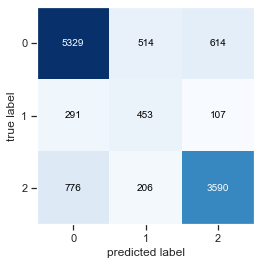

In [64]:
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

In [65]:
df_test = pd.read_csv('test_clean_data.csv')

In [66]:
df_test

,Unnamed: 0,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,decade,installer_cat,funder_cat
0,0,Dmdd,1996,DMDD,35.290799,-4.059696,Internal,Manyara,3,Mbulu,Bashay,321,True,True,2012,other,parastatal,never pay,soft,seasonal,rainwater harvesting,other,10s,Others,Others
1,1,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Pangani,Arusha,2,Arusha Rural,Kimnyaki,300,True,True,2000,gravity,vwc,never pay,soft,insufficient,spring,communal standpipe,00s,DWE,Government Of Tanzania
2,2,Unknown,1567,Unknown,34.767863,-5.004344,Internal,Singida,2,Singida Rural,Puma,500,True,False,2010,other,vwc,never pay,soft,insufficient,rainwater harvesting,other,10s,Unknown,Unknown
3,3,Finn Water,267,FINN WATER,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,43,Liwale,Mkutano,250,True,True,1987,other,vwc,unknown,soft,dry,shallow well,other,80s,Others,Others
4,4,Bruder,1260,BRUDER,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,3,Mbinga,Mbinga Urban,60,True,True,2000,gravity,water board,pay monthly,soft,enough,spring,communal standpipe,00s,Others,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,14845,Danida,34,Da,38.852669,-6.582841,Wami / Ruvu,Pwani,1,Bagamoyo,Yombo,20,True,True,1988,mono,vwc,never pay,soft,enough,river,communal standpipe,80s,Others,Danida
14846,14846,Hiap,0,HIAP,37.451633,-5.350428,Pangani,Tanga,7,Kilindi,Mvungwe,2960,True,False,1994,nira/tanira,vwc,pay annually,salty,insufficient,shallow well,hand pump,90s,Others,Others
14847,14847,Unknown,1476,Unknown,34.739804,-4.585587,Internal,Singida,2,Singida Rural,Ughandi,200,True,False,2010,gravity,vwc,never pay,soft,insufficient,dam,communal standpipe,10s,Unknown,Unknown
14848,14848,Germany,998,DWE,35.432732,-10.584159,Lake Nyasa,Ruvuma,2,Songea Rural,Maposeni,150,True,True,2009,gravity,vwc,never pay,soft,insufficient,river,communal standpipe,00s,DWE,Others


In [67]:
pd.options.display.max_columns=100

df_test.drop(columns=['Unnamed: 0','funder','installer','construction_year'],inplace=True )

df2= df_test.copy() 

df2.drop(columns=['lga','ward'],inplace=True )

df2['permit'] = df2['permit'].astype(bool).astype(int)

df2['public_meeting'] = df2['public_meeting'].astype(bool).astype(int)

# assigning categorical columns
cat_col = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','decade','installer_cat','funder_cat']

# assigning numeric columns
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gps_height             14850 non-null  int64  
 1   longitude              14850 non-null  float64
 2   latitude               14850 non-null  float64
 3   basin                  14850 non-null  object 
 4   region                 14850 non-null  object 
 5   district_code          14850 non-null  int64  
 6   population             14850 non-null  int64  
 7   public_meeting         14850 non-null  int32  
 8   permit                 14850 non-null  int32  
 9   extraction_type_group  14850 non-null  object 
 10  management             14850 non-null  object 
 11  payment                14850 non-null  object 
 12  water_quality          14850 non-null  object 
 13  quantity               14850 non-null  object 
 14  source                 14850 non-null  object 
 15  wa

In [118]:
# predictions on test set
test_pred_test = pipe.predict(df2)

In [119]:
test_pred_test

array([2, 0, 0, ..., 0, 0, 2], dtype=int64)

In [120]:
test_pred_test=pd.DataFrame(data = test_pred_test)

In [121]:
df_test = pd.read_csv('test_set_values.csv')
ids=df_test["id"]

In [122]:
test_pred_test["id"] = ids

In [123]:
test_pred_test.rename(columns={0: 'status_group'}, inplace=True)

In [124]:
test_pred_test

,status_group,id
0,2,50785
1,0,51630
2,0,17168
3,2,45559
4,0,49871
...,...,...
14845,2,39307
14846,0,18990
14847,0,28749
14848,0,33492


In [125]:
test_pred_test.set_index('id',inplace=True)

In [105]:
#test_pred_test.reset_index(inplace=True)

In [126]:
test_pred_test

,status_group
id,
50785,2
51630,0
17168,0
45559,2
49871,0
...,...
39307,2
18990,0
28749,0


In [127]:
target_status_group = {0:'functional', 
                   2: 'non functional', 
                   1: 'functional needs repair'} 
test_pred_test['status_group'] = test_pred_test['status_group'].replace(target_status_group)

In [128]:
test_pred_test

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional
...,...
39307,non functional
18990,functional
28749,functional


In [129]:
pd.DataFrame(test_pred_test).to_csv("submission_pumpit.csv")